In [3]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings
from nero import Harmonia

In [4]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [5]:
prefix = '/data/jupyter/'

#HTO_classification = pd.read_csv('/wynton/group/ye/byungjin/mux_abseq/191224_novaseq/191205_v1_1_hm_1um_HTO_classification.csv',sep=',')

In [6]:
h5_path = prefix + '200115_filtered_feature_bc_matrix.h5'
# demux_path = prefix + 'cramore/demux.output.best'
#vireo_path = '/data/191224_low_donor_ids.tsv'

In [7]:
## Read cell ranger processed h5 file
raw_adata = sc.read_10x_h5(h5_path, gex_only=False) # need gex_only = False otherwise the custom feature barcodes don't show up
raw_adata.var_names_make_unique()

reading /data/jupyter/200115_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:05)


In [8]:
adata = raw_adata.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
cell_adata = adata
cell_adata.var_names_make_unique()

In [10]:
#cell_adata_p = cell_adata[:,cell_adata.var.index[-10:]]

In [11]:
## use custom cutoff here for hg19/mm10 classification (optional)

hgenes = [x for x in cell_adata.var.index if x.startswith("hg19")]
mgenes = [x for x in cell_adata.var.index if x.startswith("mm10")]

hsum = cell_adata[:,hgenes].X.sum(axis=1)
msum = cell_adata[:,mgenes].X.sum(axis=1)
total_tx_sum = hsum + msum

hf = hsum / total_tx_sum
mf = msum / total_tx_sum

df_hf = pd.DataFrame(hf)
df_mf = pd.DataFrame(mf)

df_hsum = pd.DataFrame(hsum)
df_msum = pd.DataFrame(msum)

df_hf.columns = ['Human_tx_Fraction']
df_mf.columns = ["Mouse_tx_Fraction"]

df_hsum.columns = ['Human_tx_Fraction']
df_msum.columns = ["Mouse_tx_Fraction"]

df_fin_tx = df_hf.join(df_mf)
df_plot_tx = df_hsum.join([df_msum])


df_fin_tx.loc[df_fin_tx['Human_tx_Fraction']>=0.95, 'identity'] = 'Human'
df_fin_tx.loc[df_fin_tx['Mouse_tx_Fraction']>=0.95, 'identity'] = 'Mouse'
df_fin_tx.loc[(df_fin_tx['Human_tx_Fraction']<0.95) & (df_fin_tx['Mouse_tx_Fraction']<0.95), 'identity'] = 'Multiplet'
#df_fin_tx['identity'] = np.where(df_fin_tx['Human_tx_Fraction']>=0.9, 'Human', 'Multiplet')
#df_fin_tx['identity'] = np.where(df_fin_tx['Mouse_tx_Fraction']>=0.9, 'Mouse', 'Multiplet')

df_plots = df_plot_tx.join(df_fin_tx['identity'])
df_plots


Human_tx_Fraction  Mouse_tx_Fraction   identity
0                 6111.0             4104.0  Multiplet
1                  268.0            14396.0      Mouse
2                 5729.0             4909.0  Multiplet
3                  200.0             6416.0      Mouse
4                16913.0              344.0      Human
...                  ...                ...        ...
38676             8345.0              194.0      Human
38677              144.0             2998.0      Mouse
38678              242.0             5608.0      Mouse
38679             6721.0              147.0      Human
38680              233.0             9069.0      Mouse

[38681 rows x 3 columns]

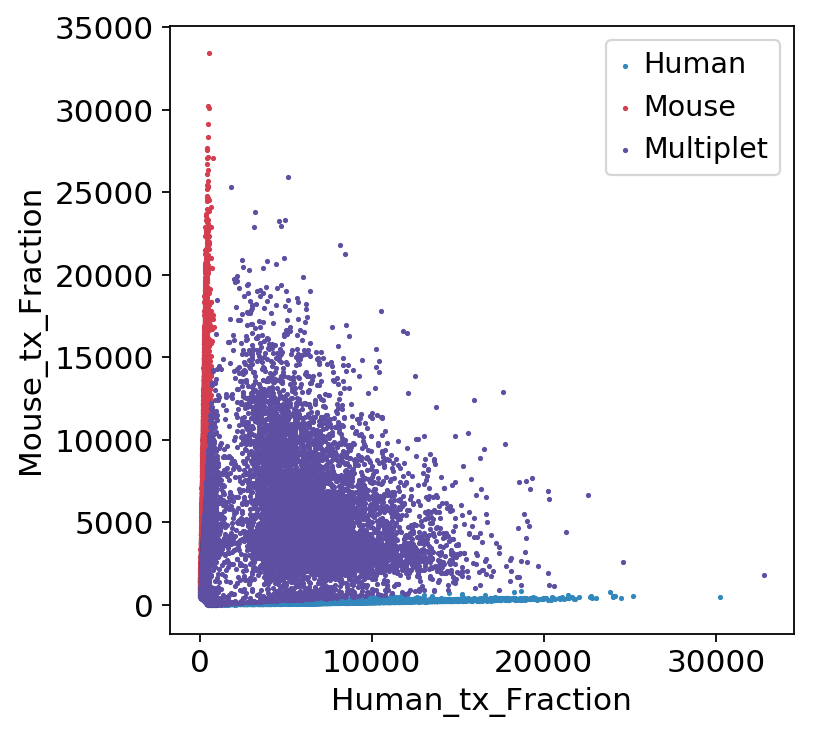

In [18]:
# check if cutoff is working

import pandas as pd
import seaborn as sns

plt.figure(figsize=(5,5))
a=df_plots[df_plots['identity']=='Human']
b=df_plots[df_plots['identity']=='Mouse']
c=df_plots[df_plots['identity']=='Multiplet']

s=sns.scatterplot(x="Human_tx_Fraction", y="Mouse_tx_Fraction", data=a, s=10, marker='.', edgecolor=None, color='#3288BD', zorder=1, label="Human")
s=sns.scatterplot(x="Human_tx_Fraction", y="Mouse_tx_Fraction", data=b, s=10, marker='.', edgecolor=None, color='#D53E4F', zorder=2, label="Mouse")
s=sns.scatterplot(x="Human_tx_Fraction", y="Mouse_tx_Fraction", data=c, s=10, marker='.', edgecolor=None, color='#5E4FA2', zorder=3, label="Multiplet")

#plt.xlim(0,10000)
#plt.ylim(0,10000)
s.grid(False)

#f = s.get_figure()
#f.savefig("191205_v1.1_20K_h_m_merged_tx_group_plot.png")

In [12]:
type(df_fin_tx['identity'])
df2 = df_fin_tx.set_index(cell_adata.obs.index)
df2
cell_adata.obs['Identity'] = df2['identity']

In [16]:
#bcs = list(cell_adata.obs.index)

In [1]:
# You can directly read cell ranger output of GEM classification file (csv)

#gem = pd.read_csv("/home/bhwang1/jupyter/200115_novaseq/200115_v1_1_hm_1um_gem_classification.csv")
#raw_gem_classification=gem[gem['barcode'].isin(bcs)]
#raw_gem_classification=raw_gem_classification.set_index('barcode')
#cell_adata.obs['identity']=raw_gem_classification['call']

In [13]:
cell_adata

AnnData object with n_obs × n_vars = 38681 × 112147 
    obs: 'Identity'
    var: 'gene_ids', 'feature_types', 'genome'

In [14]:
cell_adata.var

gene_ids     feature_types genome
hg19_DDX11L1     hg19_ENSG00000223972   Gene Expression   hg19
hg19_WASH7P      hg19_ENSG00000227232   Gene Expression   hg19
hg19_MIR1302-10  hg19_ENSG00000243485   Gene Expression   hg19
hg19_FAM138A     hg19_ENSG00000237613   Gene Expression   hg19
hg19_OR4G4P      hg19_ENSG00000268020   Gene Expression   hg19
...                               ...               ...    ...
CD29m_barcode1               Ab1CD29m  Antibody Capture       
CD29m_barcode2               Ab2CD29m  Antibody Capture       
CD29m_barcode3               Ab3CD29m  Antibody Capture       
CD29m_barcode4               Ab4CD29m  Antibody Capture       
CD29m_barcode5               Ab5CD29m  Antibody Capture       

[112147 rows x 3 columns]

Get percentage mitochondria.

In [15]:
genelist = cell_adata.var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('hg19_MT-')] + [gn for gn in genelist if gn.startswith('mm10_mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
cell_adata.obs['percent_mito'] = np.ravel(np.sum(cell_adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(cell_adata.X, axis=1))

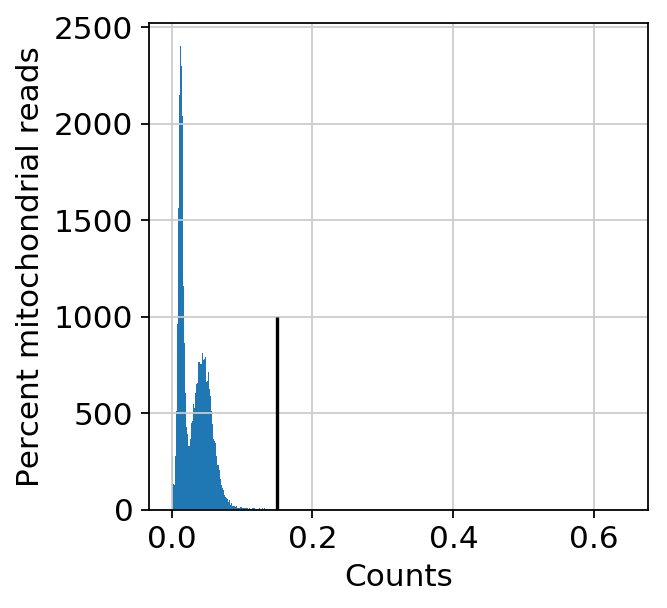

In [16]:
plt.hist(cell_adata.obs['percent_mito'].values,bins=500)
plt.vlines(0.15,0,1000);
plt.xlabel('Counts')
plt.ylabel('Percent mitochondrial reads');
# plt.xlim((0,0.1));

Only keep cells with low `percent_mito`.

In [17]:
cutoff = 0.15
cell_adata = cell_adata[cell_adata.obs['percent_mito'] < cutoff].copy()

In [18]:
cell_adata

AnnData object with n_obs × n_vars = 38504 × 112147 
    obs: 'Identity', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

Examine the number of genes expressed per cell.

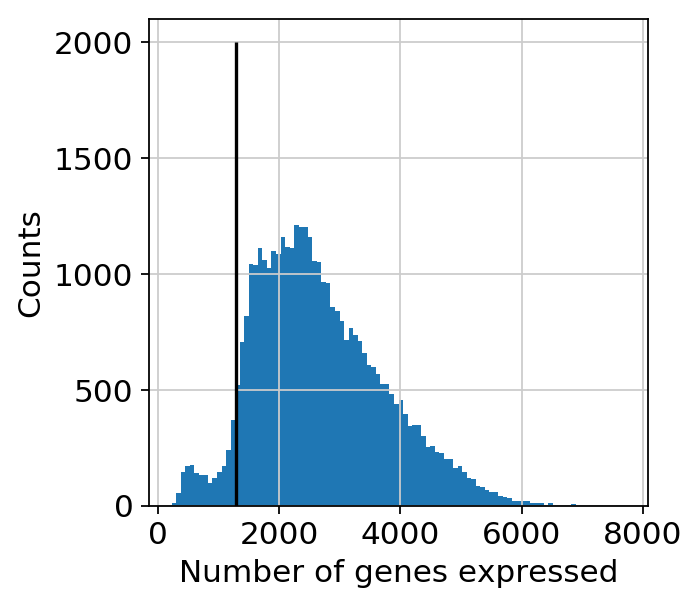

In [19]:
plt.hist(sc.pp.filter_cells(cell_adata, min_genes=0,inplace=False)[1],bins=100); # just to get out the number of genes expressed per cell
plt.ylabel('Counts')
plt.xlabel('Number of genes expressed');
plt.vlines(1300,0,2000);

I won't filter anything out here, but this may very well be a gauge for the doublets.

Standard processing here:

In [20]:
sc.pp.filter_genes(cell_adata,min_counts=1)

filtered out 55309 genes that are detected in less than 1 counts


In [21]:
cell_adata

AnnData object with n_obs × n_vars = 38504 × 56838 
    obs: 'Identity', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

In [22]:
cell_adata.var.tail(10)

gene_ids     feature_types genome    n_counts
CD29h_barcode1  Ab1CD29h  Antibody Capture          4187415.0
CD29h_barcode2  Ab2CD29h  Antibody Capture          5367925.0
CD29h_barcode3  Ab3CD29h  Antibody Capture          3523552.0
CD29h_barcode4  Ab4CD29h  Antibody Capture         14331929.0
CD29h_barcode5  Ab5CD29h  Antibody Capture         11008708.0
CD29m_barcode1  Ab1CD29m  Antibody Capture          4697718.0
CD29m_barcode2  Ab2CD29m  Antibody Capture          3276925.0
CD29m_barcode3  Ab3CD29m  Antibody Capture          2212138.0
CD29m_barcode4  Ab4CD29m  Antibody Capture          4094612.0
CD29m_barcode5  Ab5CD29m  Antibody Capture          8299949.0

# merge pool ADT counts¶

In [23]:
df_CD29h_1 = cell_adata[:,'CD29h_barcode1'].to_df()
df_CD29h_2 = cell_adata[:,'CD29h_barcode2'].to_df()
df_CD29h_3 = cell_adata[:,'CD29h_barcode3'].to_df()
df_CD29h_4 = cell_adata[:,'CD29h_barcode4'].to_df()
df_CD29h_5 = cell_adata[:,'CD29h_barcode5'].to_df()

df_CD29m_1 = cell_adata[:,'CD29m_barcode1'].to_df()
df_CD29m_2 = cell_adata[:,'CD29m_barcode2'].to_df()
df_CD29m_3 = cell_adata[:,'CD29m_barcode3'].to_df()
df_CD29m_4 = cell_adata[:,'CD29m_barcode4'].to_df()
df_CD29m_5 = cell_adata[:,'CD29m_barcode5'].to_df()

df_CD29h_merged = df_CD29h_1.join([df_CD29h_2,df_CD29h_3,df_CD29h_4,df_CD29h_5])
df_CD29m_merged = df_CD29m_1.join([df_CD29m_2,df_CD29m_3,df_CD29m_4,df_CD29m_5] )

df_CD29h_merged['CD29_h_merged'] = df_CD29h_merged.sum(axis=1)
df_CD29m_merged['CD29_m_merged'] = df_CD29m_merged.sum(axis=1)

df_CD29hm_merged = df_CD29h_merged.join(df_CD29m_merged)
#type(cell_adata.obs['call'])
df_CD29hm_merged = df_CD29hm_merged.join(cell_adata.obs)

In [24]:
df_CD29hm_merged.head()

CD29h_barcode1  CD29h_barcode2  CD29h_barcode3  \
AAACCCAAGAGGGCGA-1            10.0           725.0             7.0   
AAACCCAAGCAACCAG-1             8.0             9.0             5.0   
AAACCCAAGCCGTCGT-1            80.0            72.0            16.0   
AAACCCAAGCTATCTG-1             7.0            10.0             9.0   
AAACCCAAGCTGAAGC-1          1182.0            28.0            14.0   

                    CD29h_barcode4  CD29h_barcode5  CD29_h_merged  \
AAACCCAAGAGGGCGA-1            63.0            49.0          854.0   
AAACCCAAGCAACCAG-1            71.0            55.0          148.0   
AAACCCAAGCCGTCGT-1           130.0          1487.0         1785.0   
AAACCCAAGCTATCTG-1            88.0            67.0          181.0   
AAACCCAAGCTGAAGC-1           117.0          1976.0         3317.0   

                    CD29m_barcode1  CD29m_barcode2  CD29m_barcode3  \
AAACCCAAGAGGGCGA-1            20.0           395.0            14.0   
AAACCCAAGCAACCAG-1            13.0            15.0            10.0   
AAACCCAAGCCGTCGT-1            31.0           269.0            20.0   
AAACCCAAGCTATCTG-1            30.0            15.0            16.0   
AAACCCAAGCTGAAGC-1            37.0            35.0            21.0   

                    CD29m_barcode4  CD29m_barcode5  CD29_m_merged   Identity  \
AAACCCAAGAGGGCGA-1            31.0            52.0          512.0  Multiplet   
AAACCCAAGCAACCAG-1            36.0          2843.0         2917.0      Mouse   
AAACCCAAGCCGTCGT-1            24.0            56.0          400.0  Multiplet   
AAACCCAAGCTATCTG-1           448.0            59.0          568.0      Mouse   
AAACCCAAGCTGAAGC-1            29.0            54.0          176.0      Human   

                    percent_mito  
AAACCCAAGAGGGCGA-1      0.049305  
AAACCCAAGCAACCAG-1      0.013142  
AAACCCAAGCCGTCGT-1      0.031428  
AAACCCAAGCTATCTG-1      0.011270  
AAACCCAAGCTGAAGC-1      0.059470

In [290]:
df_CD29hm_merged.to_csv("200115_merged_raw_counts.txt")

In [37]:
df_CD29hm_merged.shape

(38504, 13)

# transform data with log1p + zscore

In [25]:
#df_call2 = df_CD4_20_h_merged['recall']
df_identity = df_CD29hm_merged['Identity']

df_drop = df_CD29hm_merged.drop(['Identity'],axis=1)

df_log1p=df_drop.apply(np.log1p)

log_znorm_df=(df_log1p-df_log1p.mean())/df_log1p.std()

In [26]:
df_fin=log_znorm_df.join([df_identity])

In [27]:
df_fin.head()

CD29h_barcode1  CD29h_barcode2  CD29h_barcode3  \
AAACCCAAGAGGGCGA-1       -0.345332        2.275420       -0.524678   
AAACCCAAGCAACCAG-1       -0.483714       -0.777242       -0.732718   
AAACCCAAGCCGTCGT-1        1.031491        0.638944        0.020421   
AAACCCAAGCTATCTG-1       -0.564938       -0.709342       -0.363309   
AAACCCAAGCTGAAGC-1        2.880555       -0.018729       -0.070092   

                    CD29h_barcode4  CD29h_barcode5  CD29_h_merged  \
AAACCCAAGAGGGCGA-1       -0.636652       -0.531239       0.421675   
AAACCCAAGCAACCAG-1       -0.530100       -0.431749      -1.128964   
AAACCCAAGCCGTCGT-1        0.011361        2.447587       1.075452   
AAACCCAAGCTATCTG-1       -0.338341       -0.261301      -0.951406   
AAACCCAAGCTGAAGC-1       -0.083187        2.697038       1.625169   

                    CD29m_barcode1  CD29m_barcode2  CD29m_barcode3  \
AAACCCAAGAGGGCGA-1       -0.660489        2.234441       -0.296968   
AAACCCAAGCAACCAG-1       -1.021189       -0.748574       -0.578564   
AAACCCAAGCCGTCGT-1       -0.285779        1.878401        0.008522   
AAACCCAAGCTATCTG-1       -0.314023       -0.748574       -0.183330   
AAACCCAAGCTGAAGC-1       -0.132902        0.005289        0.050758   

                    CD29m_barcode4  CD29m_barcode5  CD29_m_merged  \
AAACCCAAGAGGGCGA-1       -0.217086       -0.438075       0.346728   
AAACCCAAGCAACCAG-1       -0.082848        3.342409       2.219320   
AAACCCAAGCCGTCGT-1       -0.445337       -0.369009       0.081397   
AAACCCAAGCTATCTG-1        2.225094       -0.320320       0.458332   
AAACCCAAGCTGAAGC-1       -0.276759       -0.402914      -0.799555   

                    percent_mito   Identity  
AAACCCAAGAGGGCGA-1      0.899166  Multiplet  
AAACCCAAGCAACCAG-1     -0.890871      Mouse  
AAACCCAAGCCGTCGT-1      0.022105  Multiplet  
AAACCCAAGCTATCTG-1     -0.985305      Mouse  
AAACCCAAGCTGAAGC-1      1.391229      Human

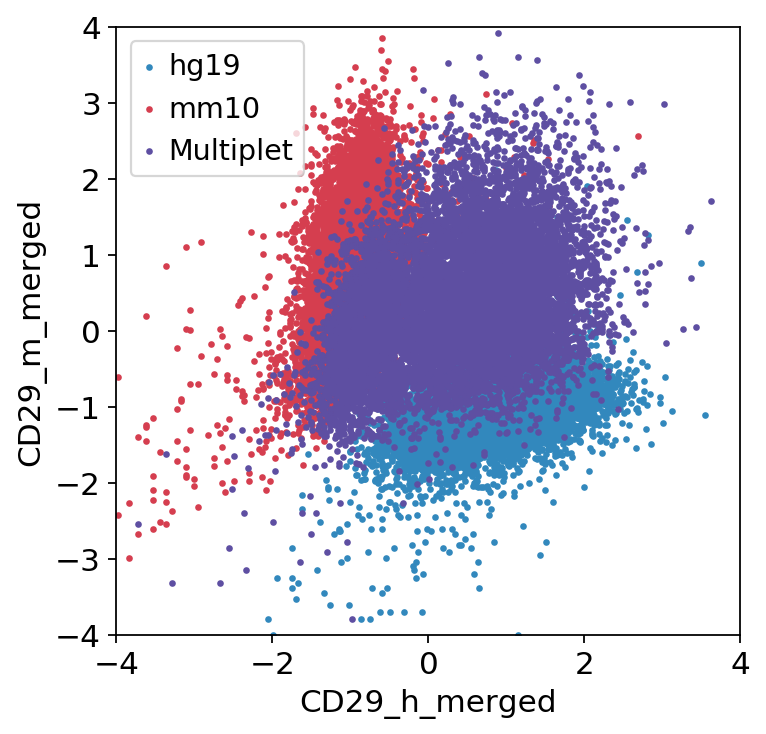

In [28]:
# QC figure before resolution

import pandas as pd
import seaborn as sns

plt.figure(figsize=(5,5))
a=df_fin[df_fin['Identity']=='Human']
b=df_fin[df_fin['Identity']=='Mouse']
c=df_fin[df_fin['Identity']=='Multiplet']

s=sns.scatterplot(x="CD29_h_merged", y="CD29_m_merged", data=a, s=20, marker='.', edgecolor=None, color='#3288BD', zorder=1, label="hg19")
s=sns.scatterplot(x="CD29_h_merged", y="CD29_m_merged", data=b, s=20, marker='.', edgecolor=None, color='#D53E4F', zorder=2, label="mm10")
s=sns.scatterplot(x="CD29_h_merged", y="CD29_m_merged", data=c, s=20, marker='.', edgecolor=None, color='#5E4FA2', zorder=3, label="Multiplet")

plt.xlim(-4,4)
plt.ylim(-4,4)
s.grid(False)

f = s.get_figure()
#f.savefig("200115_v1.1_100K_h_m_merged_tx_group_plot.png")

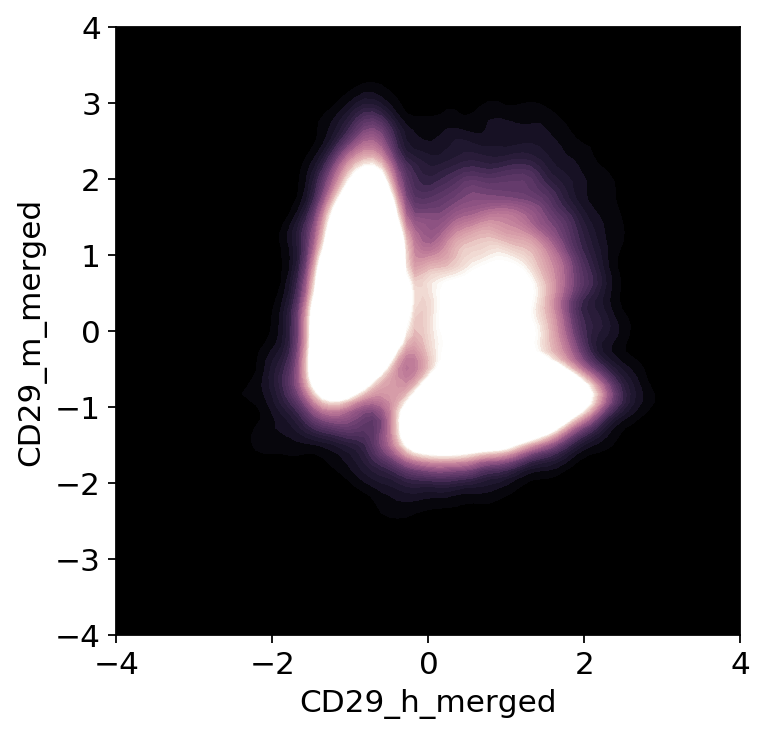

In [37]:
#desntiy plot
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=7, reverse=True)
g=sns.kdeplot(df_fin.CD29_h_merged, df_fin.CD29_m_merged, cmap=cmap, n_levels=300, shade=True);
plt.autoscale(True)
g.set(ylim=(-4,4))
g.set(xlim=(-4,4))
g.grid(False)

f = g.get_figure()
f.savefig("200115_v1.1_100K_h_m_unresolved_density_plot.png")

# resolution plots

In [3]:
# processed from the R code (mouse_human_analysis.R)
df_submission = pd.read_table("20200305_100k_hm_total_ab_log_norm.tab", sep="\t")
df_submission
#np.unique(df_submission['tx_type'])
#df_submission[df_submission['jimmie']!='0_0'&df_submission['tx_type']!='hg19']
df_fin = df_submission[(df_submission['htodemux.cell_type']!='0_0')]
x=df_fin[df_fin['manual1d.cell_type']=='1_2']
x.shape[0]/df_fin.shape[0]
df_fin.shape[0]

46295

In [9]:
np.unique(df_submission['ab_droplet_type'])

array(['doublet_cross_ct', 'doublet_same_ct', 'singlet', 'unstained'],
      dtype=object)

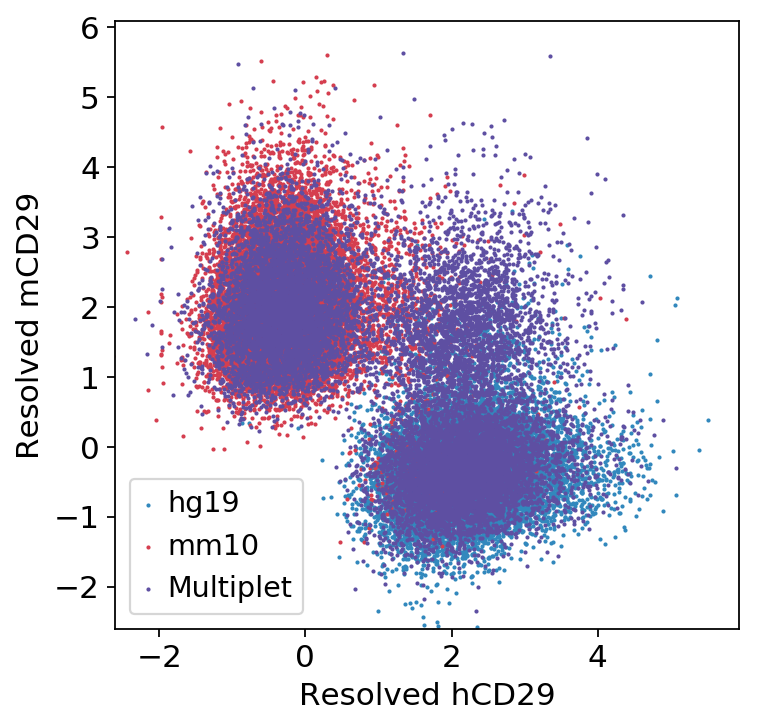

In [13]:
 import seaborn as sns

plt.figure(figsize=(5,5))
a=df_submission[(df_submission['htodemux.cell_type']!='0_0') &(df_submission['tx_type']=='hg19')]
b=df_submission[(df_submission['htodemux.cell_type']!='0_0') &(df_submission['tx_type']=='mm10')]
c=df_submission[(df_submission['htodemux.cell_type']!='0_0') &(df_submission['tx_type']=='doublet_cross_ct')]
#d=df_submission[(df_submission['jimmie']!='0_0') & (df_submission['ab_droplet_type']=='unstained')]

s=sns.scatterplot(x="ct1", y="ct2", data=a, s=5, marker='.', edgecolor=None, color='#3288BD', zorder=1, label='hg19')
s=sns.scatterplot(x="ct1", y="ct2", data=b, s=5, marker='.', edgecolor=None, color='#D53E4F', zorder=2, label='mm10')
s=sns.scatterplot(x="ct1", y="ct2", data=c, s=5, marker='.', edgecolor=None, color='#5E4FA2', zorder=3, label='Multiplet')
#s=sns.scatterplot(x="ct1", y="ct2", data=d, s=3, marker='.', edgecolor=None, color='gray', zorder=4, label='negatives')


plt.xlabel("Resolved hCD29")
plt.ylabel("Resolved mCD29")

plt.xlim(-2.6)
plt.ylim(-2.6)
s.grid(False)

f = s.get_figure()
f.savefig("200115_v1.1_100K_hm_resolved_clean_tx_group_plot_final.png")

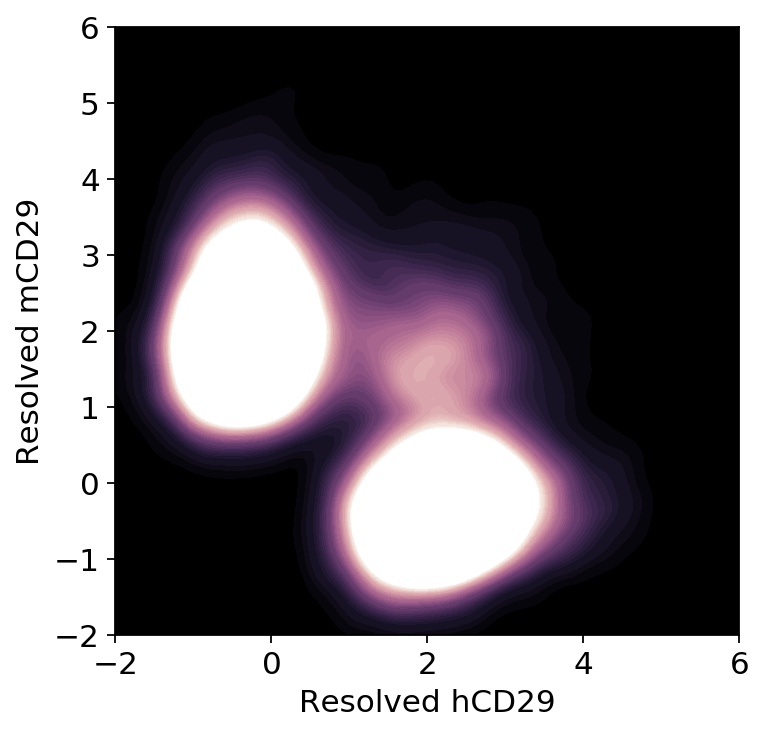

In [12]:
import seaborn as sns
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=7, reverse=True)


g=sns.kdeplot(df_fin.ct1, df_fin.ct2, cmap=cmap, n_levels=300, shade=True);
plt.autoscale(True)
g.set(ylim=(-2,6))
g.set(xlim=(-2,6))
g.set(xlabel='Resolved hCD29')
g.set(ylabel='Resolved mCD29')
g.grid(False)

f = g.get_figure()
f.savefig("200115_v1.1_100K_hm_resolved_density_plot_final.png")

# plot UMAP to get the cell type info

In [25]:
cell_adata2 = cell_adata[:,cell_adata.var.index[:-10]]

In [26]:
sc.pp.normalize_per_cell(cell_adata2, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [27]:
sc.pp.log1p(cell_adata2)

Extract out highly variable genes, but don't subset just yet.

In [28]:
hv_out = sc.pp.highly_variable_genes(cell_adata2, inplace=False)

extracting highly variable genes
    Gene indices [44617] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:04)


In [29]:
cell_adata2.var.tail(10)

gene_ids    feature_types genome  n_counts
mm10_AC133103.1      mm10_ENSMUSG00000079190  Gene Expression   mm10       1.0
mm10_Csprs           mm10_ENSMUSG00000062783  Gene Expression   mm10      44.0
mm10_AC132444.6      mm10_ENSMUSG00000096808  Gene Expression   mm10       2.0
mm10_AC125149.3      mm10_ENSMUSG00000079800  Gene Expression   mm10      11.0
mm10_AC125149.2      mm10_ENSMUSG00000079794  Gene Expression   mm10       2.0
mm10_AC125149.4      mm10_ENSMUSG00000094799  Gene Expression   mm10       1.0
mm10_AC168977.1      mm10_ENSMUSG00000079808  Gene Expression   mm10       2.0
mm10_AC149090.1      mm10_ENSMUSG00000095041  Gene Expression   mm10   12871.0
mm10_CAAA01118383.1  mm10_ENSMUSG00000063897  Gene Expression   mm10    1586.0
mm10_CAAA01147332.1  mm10_ENSMUSG00000095742  Gene Expression   mm10     440.0

In [30]:
keep_genes = cell_adata2.var_names[hv_out['highly_variable']].tolist()
#proteins = ['CD3barcode1', 'CD3barcode2', 'CD20barcode1', 'CD20barcode2']
# proteins = ['CD4-BC1', 'CD4-BC2', 'CD14-BC1', 'CD14-BC2']

Are our proteins highly variable?

In [32]:
#[i in keep_genes for i in proteins]

[False, False, False, False]

Regress out unwanted variation.

In [31]:
cell_adata = cell_adata2[:,keep_genes]
#cell_adata = cell_adata[:,keep_genes + proteins].copy()

In [29]:
#sc.pp.regress_out(cell_adata,['percent_mito','n_counts'],n_jobs=40)

regressing out ['percent_mito', 'n_counts']
    sparse input is densified and may lead to high memory use


... storing 'DROPTYPE' as categorical
... storing 'IND' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


    finished (0:01:02)


In [32]:
sc.pp.scale(cell_adata2, max_value=10)

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption.
    ... clipping at max_value 10


Cluster on just the mRNA and then we'll add our protein markers back later.

In [33]:
cell_adata_mrnahv = cell_adata2[:,keep_genes].copy()
#cell_adata_p = cell_adata[:,proteins].copy()

Begin clustering and dimensionality reduction.

In [34]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(cell_adata_mrnahv,n_neighbors=10) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:30)
    computed neighbors (0:00:41)
    computed connectivities (0:00:03)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:44)


In [35]:
# resolution to 0.2 for small number of clusters 
sc.tl.leiden(cell_adata_mrnahv,resolution=0.2)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


In [36]:
sc.tl.umap(cell_adata_mrnahv,min_dist=2,gamma=50)

computing UMAP


/home/bhwang1/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


In [37]:
cell_adata_mrnahv

AnnData object with n_obs × n_vars = 38504 × 6960 
    obs: 'Identity', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'log1p', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'

... storing 'Identity' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


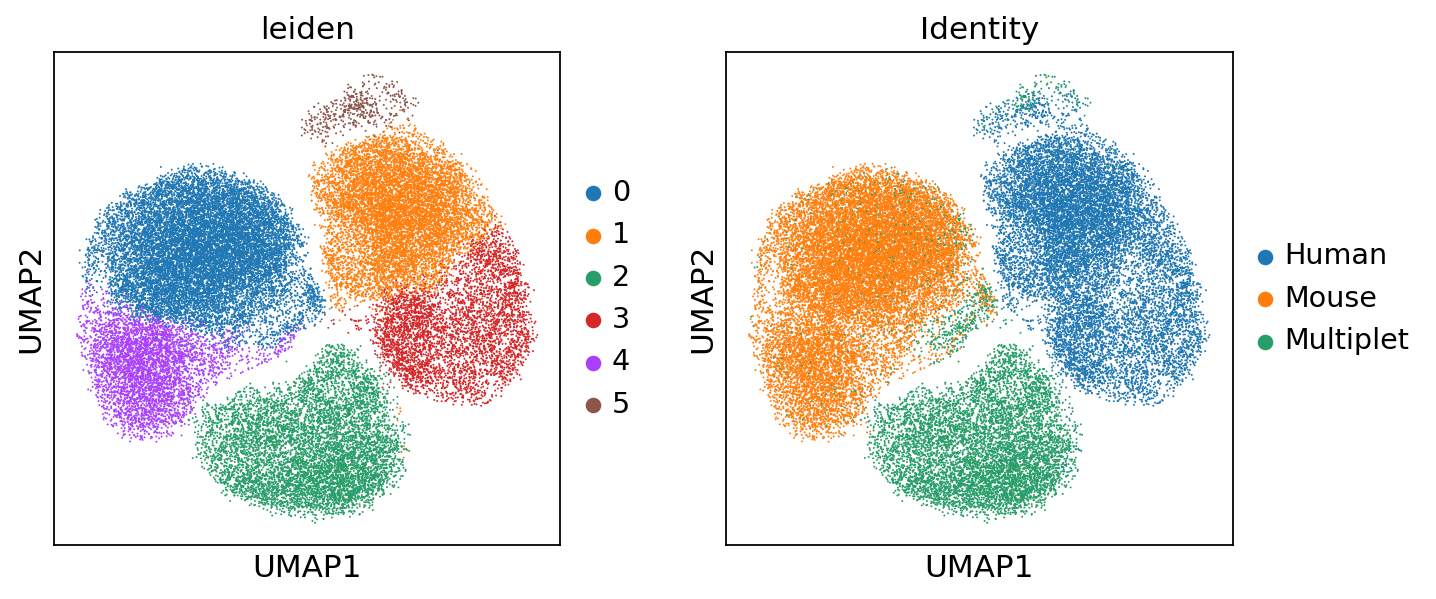

In [38]:
sc.pl.umap(cell_adata_mrnahv,color=['leiden','Identity'])
#sc.pl.umap(cell_adata_mrnahv, color=['IL7R', 'MS4A1'], use_raw=False, vmin=0, vmax=2)
#sc.pl.umap(cell_adata, color=['leiden', 'IL7R', 'MS4A1'])

In [40]:
new_cluster_names = ['CD4 T cells','B cells','Doublets']
cell_adata_mrnahv.rename_categories('leiden', new_cluster_names)

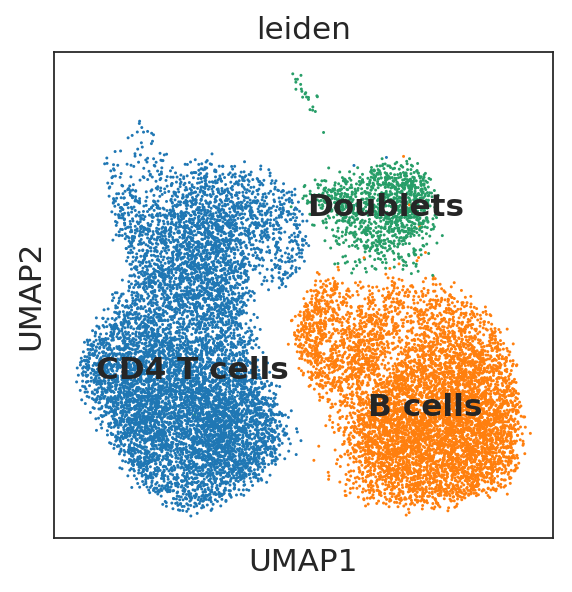

In [41]:
sc.pl.umap(cell_adata_mrnahv, color='leiden', legend_loc='on data')

In [42]:
cell_adata_mrnahv

AnnData object with n_obs × n_vars = 16783 × 2901 
    obs: 'DROPTYPE', 'IND', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'log1p', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'DROPTYPE_colors'
    obsm: 'X_pca', 'X_umap'

In [43]:
cell_adata_mrnahv.obs['leiden'].shape

(16783,)

In [44]:
df_cell_type = cell_adata_mrnahv.obs['leiden']

In [39]:
# import merged matrix and make adata object to combine with RNA UMAP adata object below

a=df_fin['CD29_h_merged'].to_frame()
b=df_fin['CD29_m_merged'].to_frame()
#c=ctype_gmm_df['CD20barcode1'].to_frame()
#d=ctype_gmm_df['CD20barcode2'].to_frame()
merged_adt = a.join([b])
#pgmm.columns=['CD4barcode1','CD4barcode2','CD20barcode1','CD20barcode2']
merged_adt_adata = sc.AnnData(merged_adt)

In [40]:
merged_adt_adata

AnnData object with n_obs × n_vars = 38504 × 2 

# concatenate back the proteins with log_zscore normalized ADT counts

In [41]:
cell_adata_mrnahv.X = csr_matrix(cell_adata_mrnahv.X) 
cell_adata_comb = cell_adata_mrnahv.T.concatenate(merged_adt_adata.T).T.copy()

Keep all the nice unstructured (uns) data and multi-D annotations of observations (obsm).

In [42]:
cell_adata_comb.uns = cell_adata_mrnahv.uns # copy over the umap and leiden data
cell_adata_comb.obsm = cell_adata_mrnahv.obsm # copy over the umap and leiden data

In [43]:
cell_adata_comb.obs.columns

Index(['Identity-0', 'percent_mito-0', 'n_counts-0', 'leiden-0'], dtype='object')

In [44]:
cell_adata_comb.var

batch    feature_types                 gene_ids genome  \
hg19_hsa-mir-6723-0     0  Gene Expression     hg19_ENSG00000237973   hg19   
hg19_LINC00115-0        0  Gene Expression     hg19_ENSG00000225880   hg19   
hg19_SAMD11-0           0  Gene Expression     hg19_ENSG00000187634   hg19   
hg19_HES4-0             0  Gene Expression     hg19_ENSG00000188290   hg19   
hg19_ISG15-0            0  Gene Expression     hg19_ENSG00000187608   hg19   
...                   ...              ...                      ...    ...   
mm10_mt-Nd5-0           0  Gene Expression  mm10_ENSMUSG00000064367   mm10   
mm10_mt-Nd6-0           0  Gene Expression  mm10_ENSMUSG00000064368   mm10   
mm10_AC149090.1-0       0  Gene Expression  mm10_ENSMUSG00000095041   mm10   
CD29_h_merged-1         1              NaN                      NaN    NaN   
CD29_m_merged-1         1              NaN                      NaN    NaN   

                     n_counts  
hg19_hsa-mir-6723-0   13270.0  
hg19_LINC00115-0        565.0  
hg19_SAMD11-0         18448.0  
hg19_HES4-0           12298.0  
hg19_ISG15-0          55144.0  
...                       ...  
mm10_mt-Nd5-0         88394.0  
mm10_mt-Nd6-0         24090.0  
mm10_AC149090.1-0     12871.0  
CD29_h_merged-1           NaN  
CD29_m_merged-1           NaN  

[6962 rows x 5 columns]

Do some cleanup.

In [81]:
# cell_adata_comb.obs.drop(['DROPTYPE-1','IND-1'],axis=1,inplace=True) # clean up the obs
#cell_adata_comb.obs.columns = ['DROPTYPE-0','IND-0','percent_mito','n_counts','leiden-0','DROPTYPE-1', 'IND-1'] # clean up the obs

In [82]:
#cell_adata_comb.var_names = cell_adata_mrnahv.var_names.tolist() + cell_adata_p.var_names.tolist() # clean up those var names

Visualize!

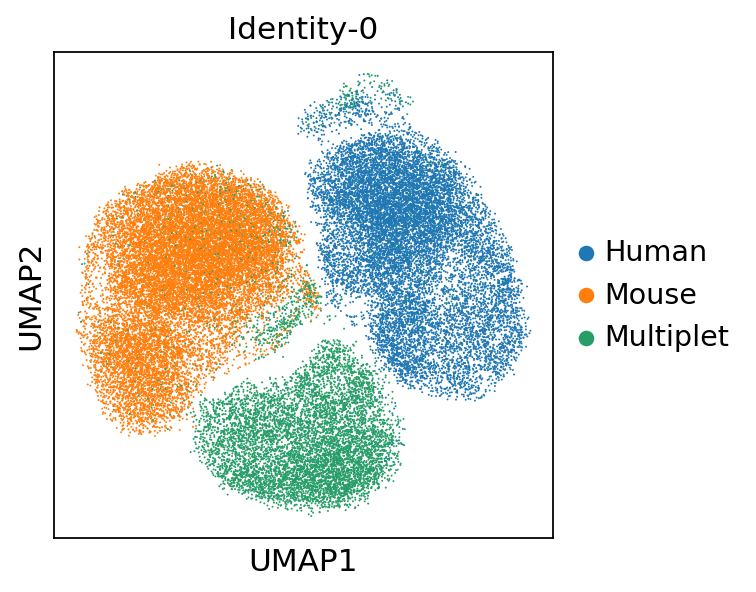

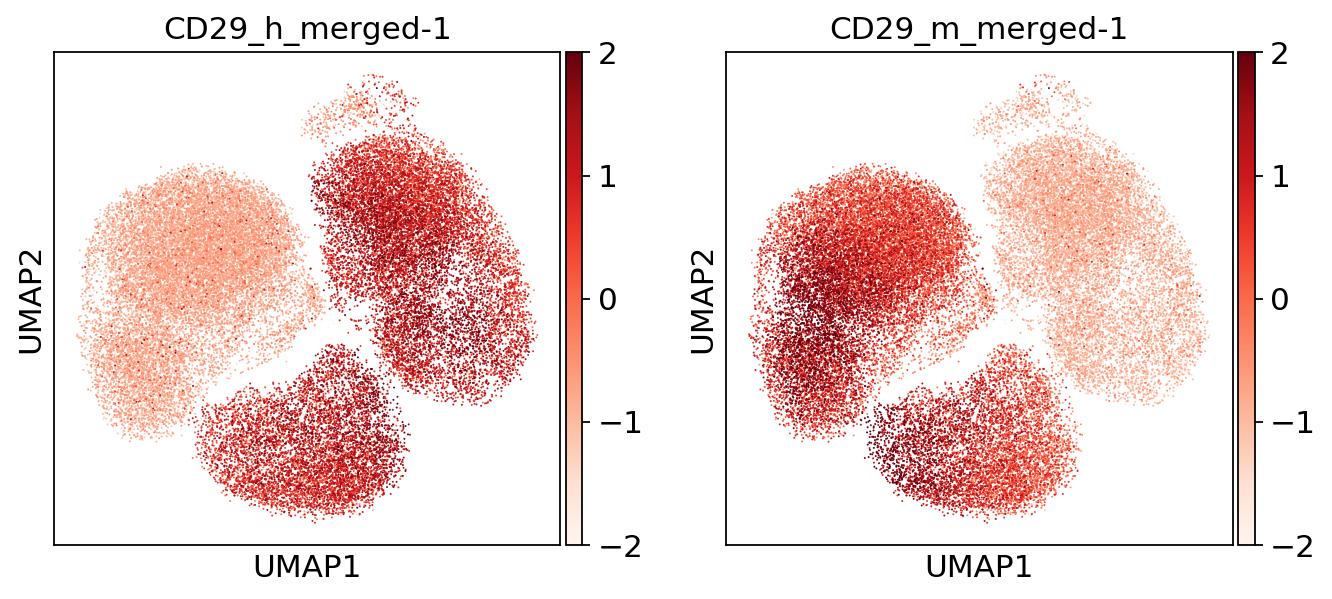

In [46]:
import matplotlib as mpl
#sc.pl.umap(cell_adata_comb,color='leiden-0')
sc.pl.umap(cell_adata_comb,color='Identity-0', save="200115_hm_umap_identity.png")
sc.pl.umap(cell_adata_comb,color=['CD29_h_merged-1','CD29_m_merged-1'], vmin=-2, vmax=2,palette="Set2", color_map=mpl.cm.Reds, save="200115_hm_umap_merged_adt.png")
#sc.pl.umap(cell_adata_comb,color='percent_mito-0')
#sc.pl.umap(cell_adata_comb,color='n_counts-0')

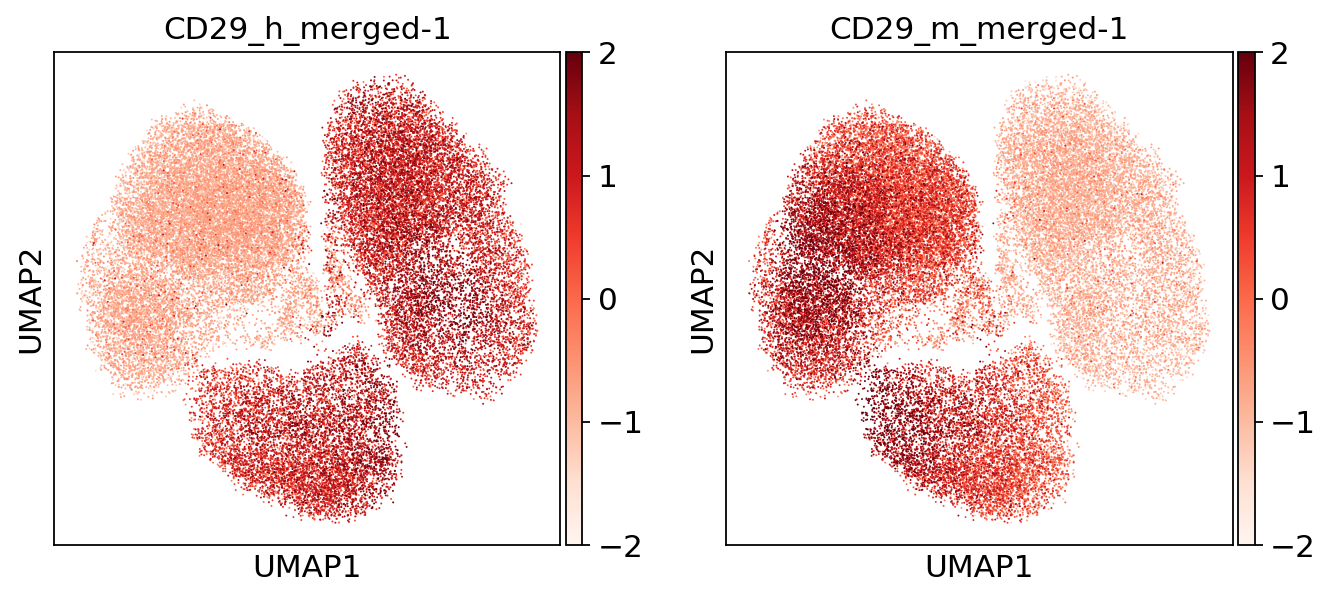

In [54]:
import matplotlib as mpl
sc.pl.umap(cell_adata_comb,color=['CD29_h_merged-1','CD29_m_merged-1'], vmin=-2, vmax=2,palette="Set2", color_map=mpl.cm.Reds)